# Hierarchical Clustering

## Autoreload

Autoreload allows the notebook to dynamically load code: if we update some helper functions *outside* of the notebook, we do not need to reload the notebook.

In [1]:
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import procyclingstats as pcs
import umap

from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering

# Otherwise nothing will be found
sys.path.append(os.path.abspath(os.path.join('..')))

from utility.cluster_utility import scale_data, hier_search, get_average_per_cluster

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-30 15:32:38.733914: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Global variables, constants, etc.

In [3]:
sys.path.append('../dataset/')
sys.path.append('../utility/')

# Global variables, constants
IMAGE_DIR = '../images/'
RANDOM_STATE = 42
hyperparametrs = {
    'n_clusters': np.arange(3, 10), # starting from 3 because with 2 clusters we just get outlier detection
    'linkage': ['single', 'complete', 'average', 'ward']
}
RUN_GRID_SEARCH = True

We've spent a lot of effort into engineering new features, understanding them, etc. Whether we've done this well and whether is enough it's a different story.

The point here is that - after the understanding, engineering and transformation - we have some cleaned-up versions of the datasets.

In [4]:
cyclists_df = pd.read_csv('../dataset/cyclists_cleaned.csv')
races_df = pd.read_csv('../dataset/races_cleaned.csv')

Let's reduce the dimensionality of the dataset by dropping useless or non-descriptive columns. The last three columns of `cyclists_df` have been dropped because of their correlation with other columns and the presence of strong outliers

In [5]:
cyclists_df = cyclists_df.select_dtypes(include=[np.number])
cyclists_df = cyclists_df.drop(columns=['birth_year', 'weight', 'height', 'avg_points_per_race', 'mean_stamina_index', 'victories_by_points'])
cyclists_df = cyclists_df.dropna()

In [6]:
races_df = races_df.select_dtypes(include=[np.number])
races_df = races_df.drop(columns=['uci_points', 'quality_adjusted_points', 'position', 'delta', 'cyclist_age', 'age_performance_index', 'profile', 
                                  'season', 'norm_points', 'normalized_length', 'normalized_quality', 'normalized_steepness', 'time_seconds', 'normalized_time', 'stamina_index'])
races_df = races_df.dropna()

Because of its high resemblance to a categorical variable (check the data understanding notebook for proof), we decided to remove the `points` column to weed out bad clusters. While `steepness` defines a relation between `length` and `climb_total`, we thought that hierarchical clustering could benefit from this feature because it is quite correlated with `profile`, which is categorical, and is a continuous variable with a distribution that has no sensational outliers (thus not impairing the clustering algorithms).

In [7]:
races_df = races_df.drop(columns=['points'])
races_df = races_df.drop_duplicates()

# Cyclists

Let's scale the data

In [13]:
cyc_normalizer, cyc_normalized = scale_data(cyclists_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [16]:
if RUN_GRID_SEARCH: search_results = hier_search(hyperparametrs, cyc_normalized)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 28 is smaller than n_iter=80. Running 28 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Let's check them

In [17]:
if RUN_GRID_SEARCH: display(search_results)

n_clusters   linkage  random_state  silhouette
0            3    single            42    0.775487
1            4    single            42    0.729948
14           3   average            42    0.461807
2            5    single            42    0.449895
3            6    single            42    0.425771
4            7    single            42    0.423144
15           4   average            42    0.420770
5            8    single            42    0.419791
7            3  complete            42    0.393271
16           5   average            42    0.371129
17           6   average            42    0.286759
18           7   average            42    0.281244
19           8   average            42    0.280518
20           9   average            42    0.275789
6            9    single            42    0.269327
21           3      ward            42    0.230024
22           4      ward            42    0.221814
23           5      ward            42    0.156696
24           6      ward            42    0.147469
10           6  complete            42    0.142604
25           7      ward            42    0.141026
11           7  complete            42    0.137613
9            5  complete            42    0.123958
12           8  complete            42    0.121680
8            4  complete            42    0.116716
26           8      ward            42    0.115070
27           9      ward            42    0.114019
13           9  complete            42    0.102767

Looks like the best silhouette score is reached by single linkages with 3 clusters. 

Let's try to plot it

In [18]:
single_linkage = AgglomerativeClustering(n_clusters=3, linkage='single')
labels = single_linkage.fit_predict(cyc_normalized)

In [19]:
cyclists_df['cluster'] = labels

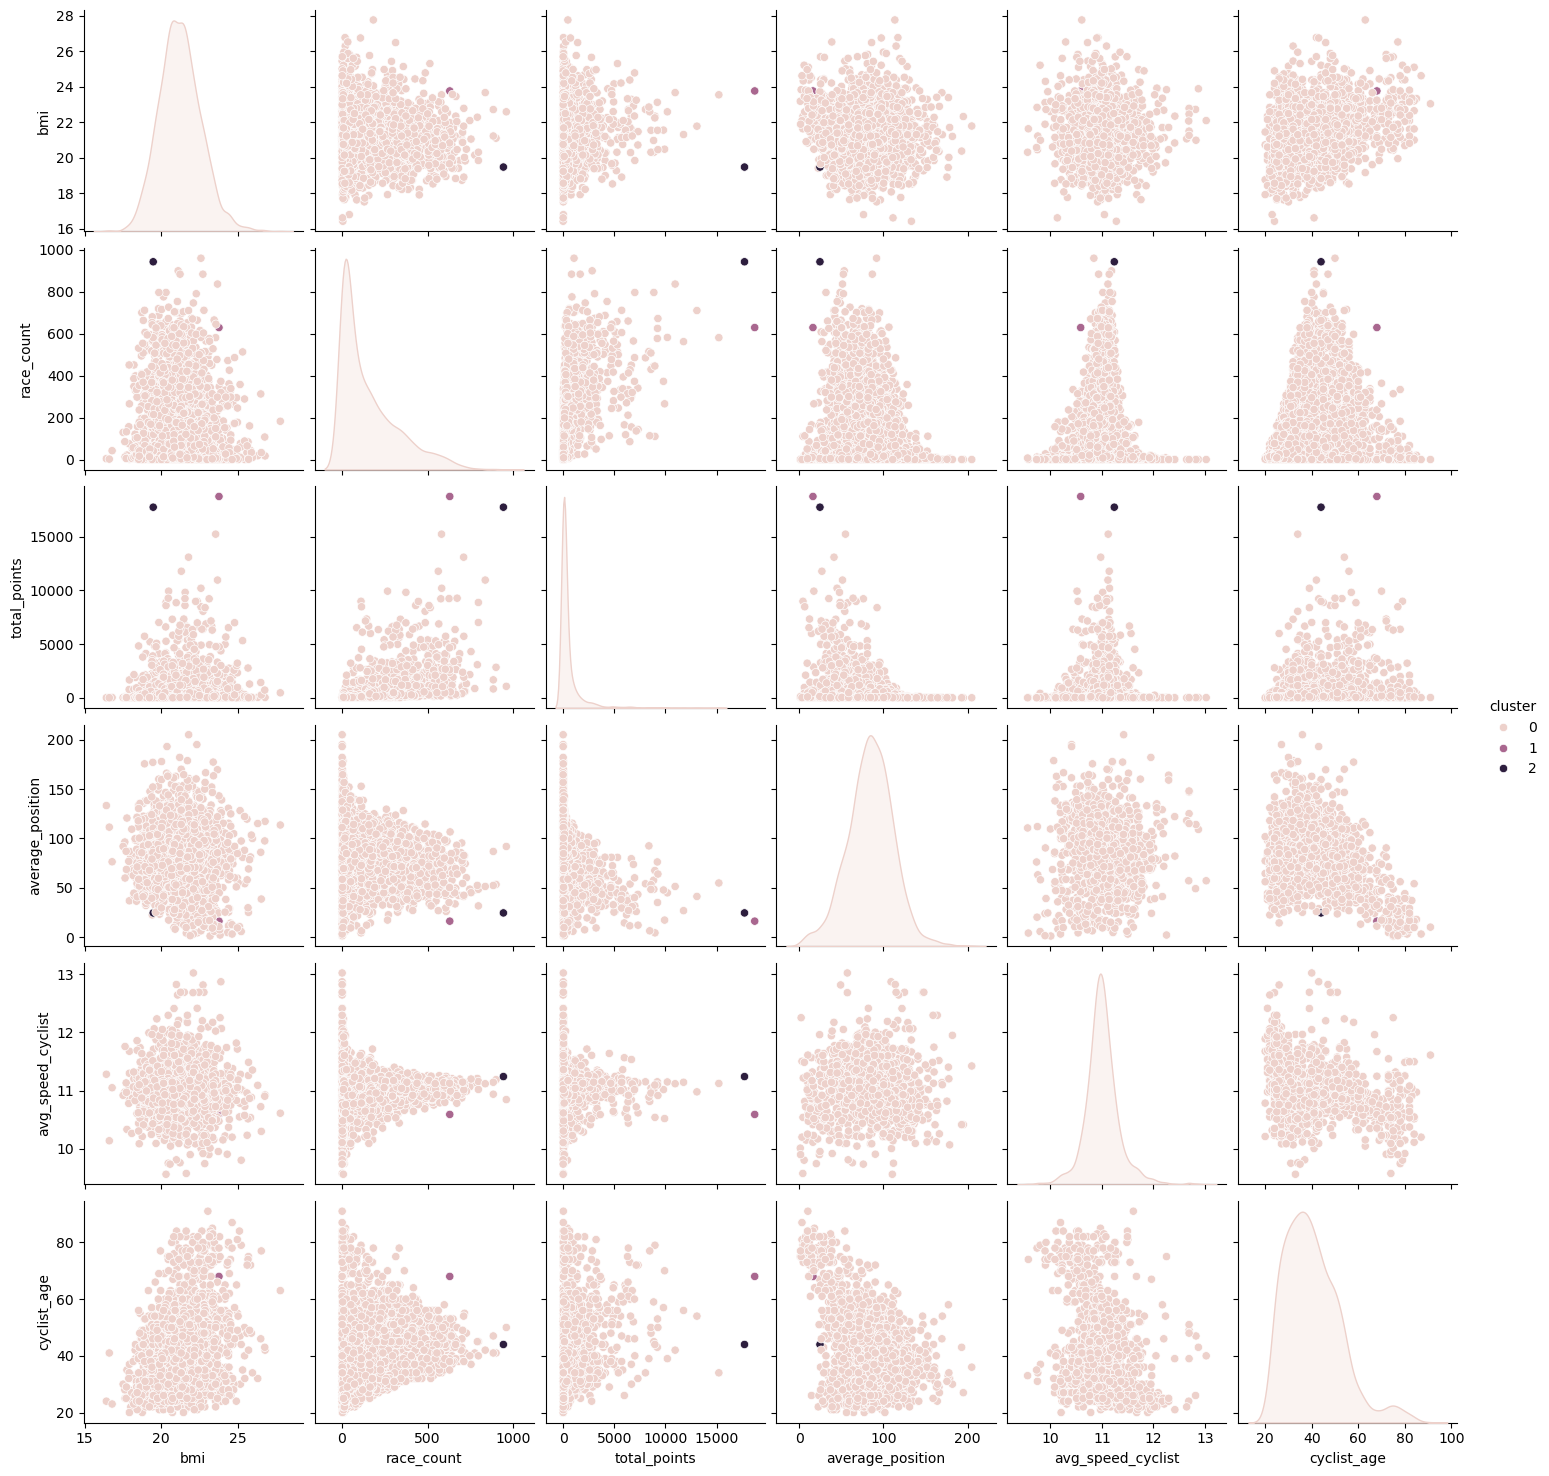

In [20]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

And it just looks like a mediocre result for outlier detection! As expected, MIN suffers a lot from outliers and noise. Let's check how the best average works

In [21]:
average_linkage = AgglomerativeClustering(n_clusters=3, linkage='average')
labels = average_linkage.fit_predict(cyc_normalized)

In [22]:
cyclists_df['cluster'] = labels

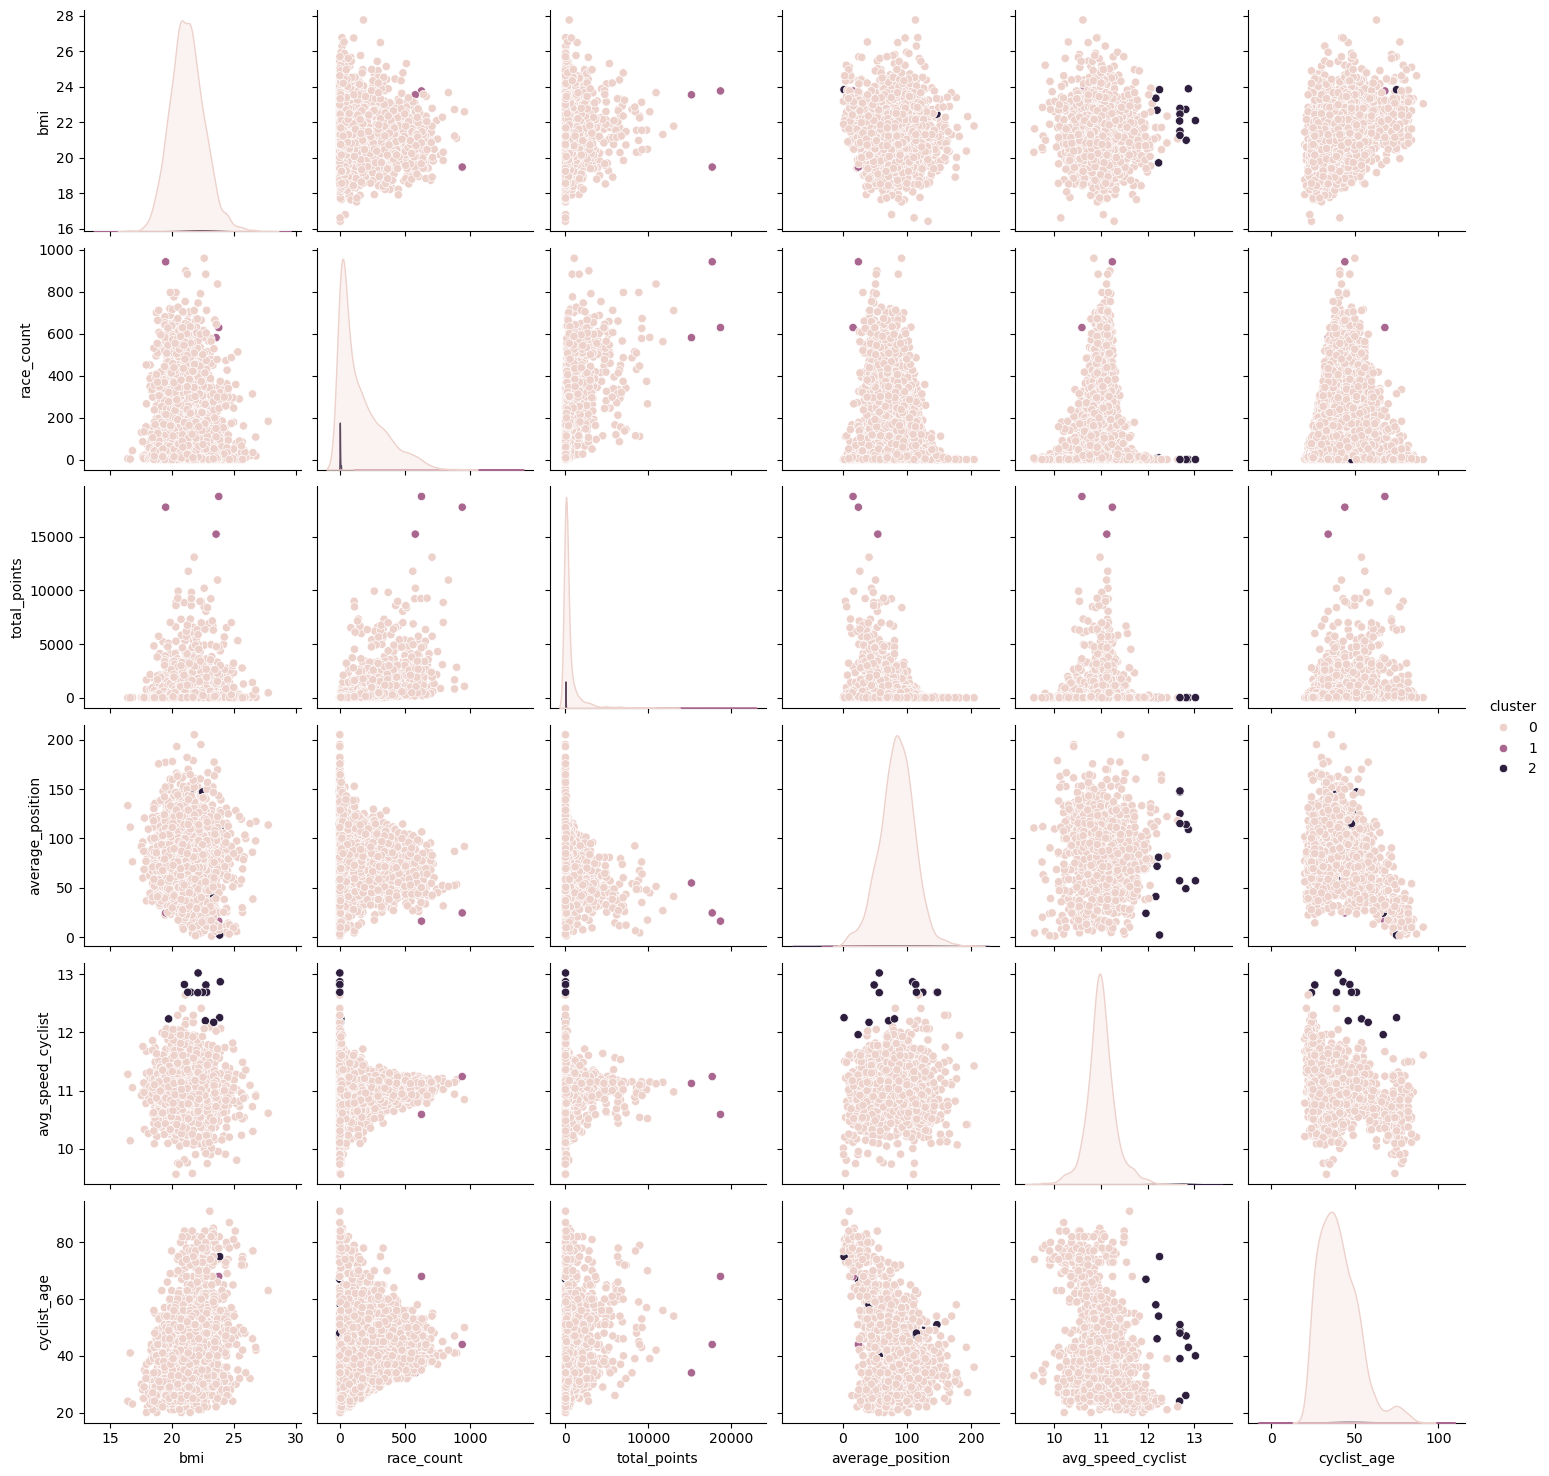

In [23]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

It's still suffering, albeit doing a bit better. The main reason seems to be some cyclists having totalized a great deal of points and some having high speeds. Let's check how MAX goes.

In [25]:
# show only the rows of silhouettes where linkage = 'complete'

if RUN_GRID_SEARCH: display(search_results[search_results['linkage'] == 'complete'])

n_clusters   linkage  random_state  silhouette
7            3  complete            42    0.393271
10           6  complete            42    0.142604
11           7  complete            42    0.137613
9            5  complete            42    0.123958
12           8  complete            42    0.121680
8            4  complete            42    0.116716
13           9  complete            42    0.102767

In [26]:
complete_linkage = AgglomerativeClustering(n_clusters=3, linkage='complete')
labels = complete_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

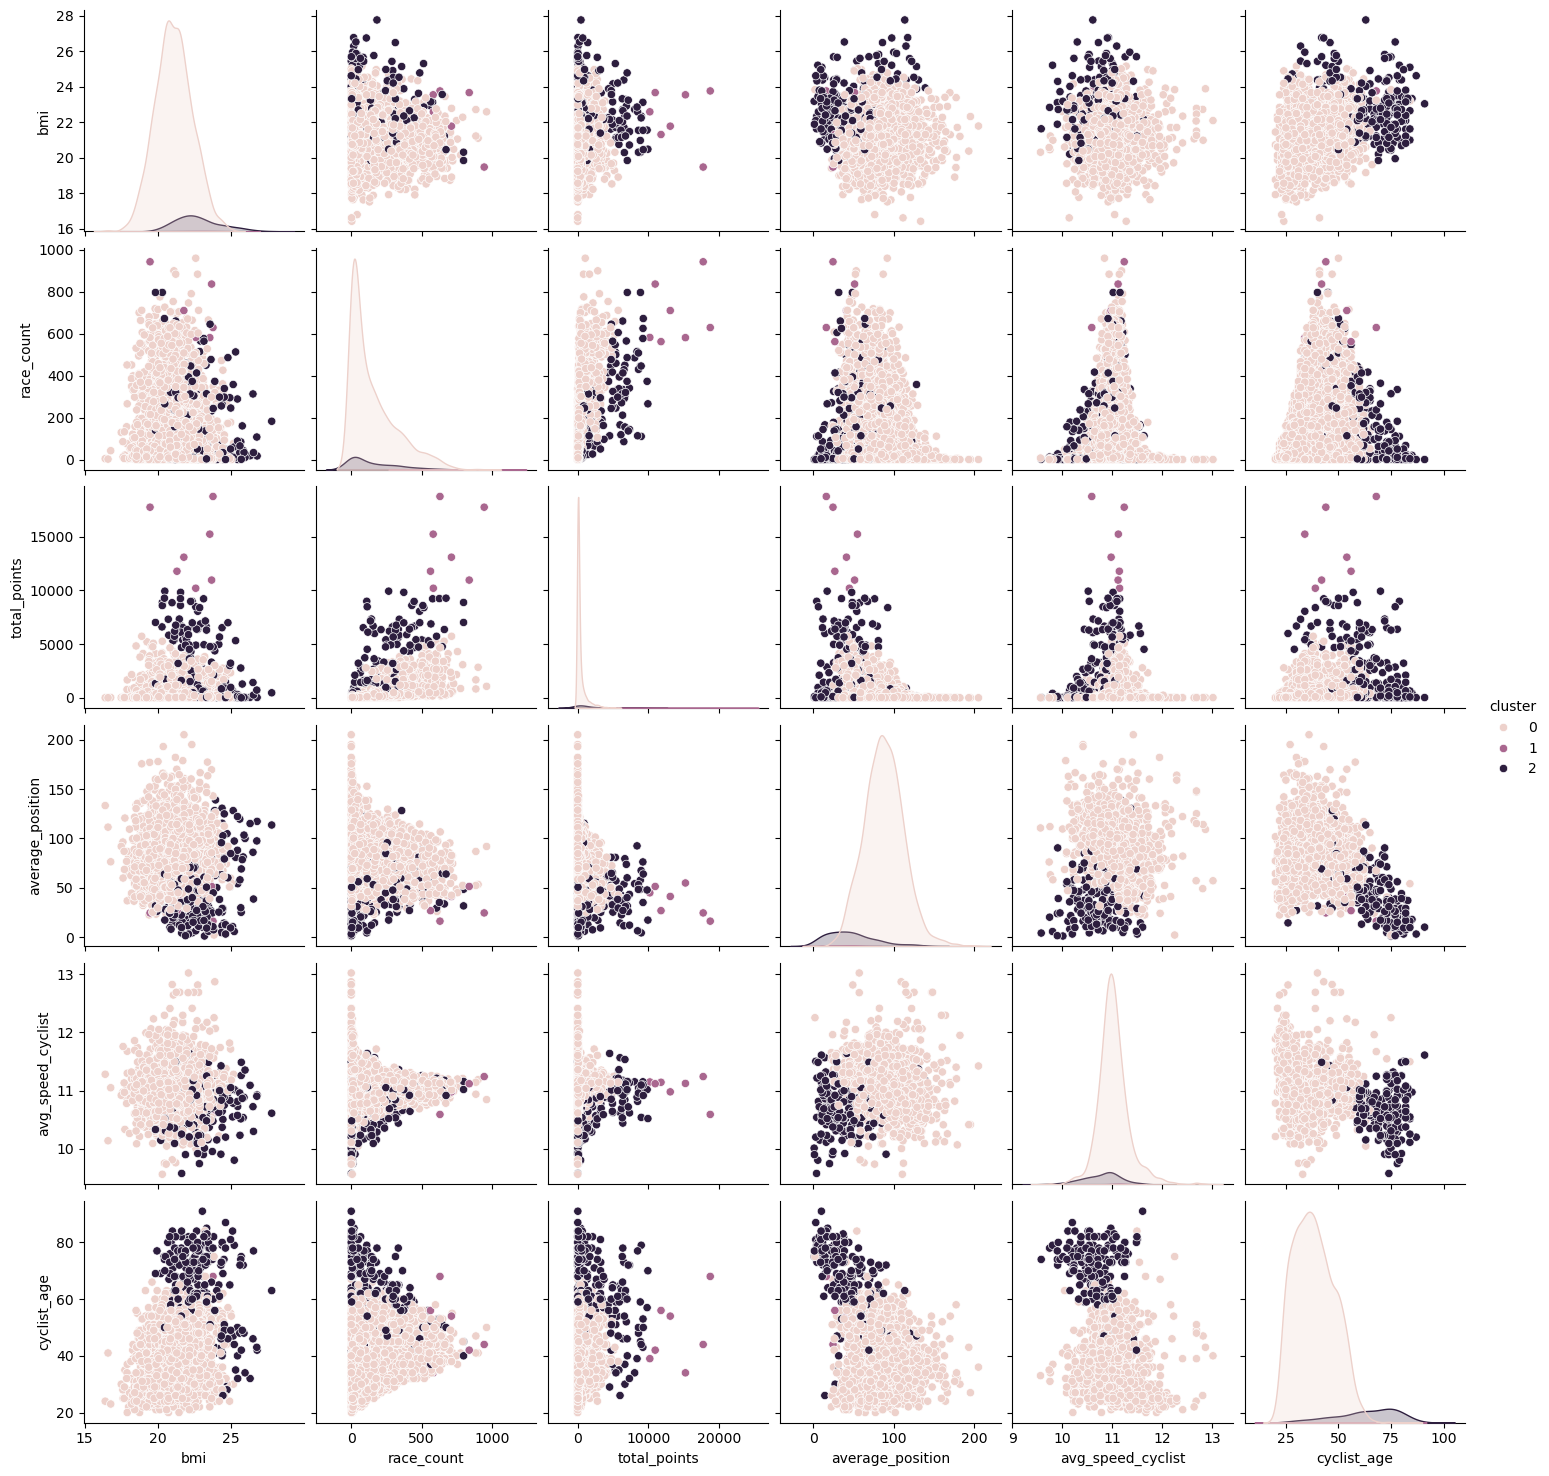

In [27]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

Well, a bit of a more satisfying division.

In [28]:
avg_cycl, _ = get_average_per_cluster(labels, cyclists_df)
avg_cycl

bmi  race_count  total_points  average_position  \
cluster                                                          
0        21.077027  154.685765    368.266904         87.418923   
1        22.303936  691.714286  13951.142857         37.000781   
2        22.737752  160.912500   2217.270833         46.398661   

         avg_speed_cyclist  cyclist_age  cluster_size  
cluster                                                
0                11.021402    38.457651          2810  
1                11.049186    48.142857             7  
2                10.779605    63.416667           240

The first cluster represents the bulk of amateur cyclists that are mostly young, did not reach impressive average positions and did not accumulate an high number of total points.<br>
The second cluster represents a small group of competitive cyclists that perform exceedingly well and have the highest experience. This is basically a set of outliers <br>
The third cluster consists of cyclists that managed to distinguish themselves from the amateurs for their performances. Considering the mean age of this cluster, we can without doubt say that most of the cyclists belonging to this cluster are historical cyclists that left their mark both in the history books and in these clusters.


Let's check how Ward's Method fared

In [29]:
# show only the rows of silhouettes where linkage = 'complete'

if RUN_GRID_SEARCH: display(search_results[search_results['linkage'] == 'ward'])

n_clusters linkage  random_state  silhouette
21           3    ward            42    0.230024
22           4    ward            42    0.221814
23           5    ward            42    0.156696
24           6    ward            42    0.147469
25           7    ward            42    0.141026
26           8    ward            42    0.115070
27           9    ward            42    0.114019

In [30]:
ward_linkage = AgglomerativeClustering(n_clusters=3, linkage='ward')
labels = ward_linkage.fit_predict(cyc_normalized)
cyclists_df['cluster'] = labels

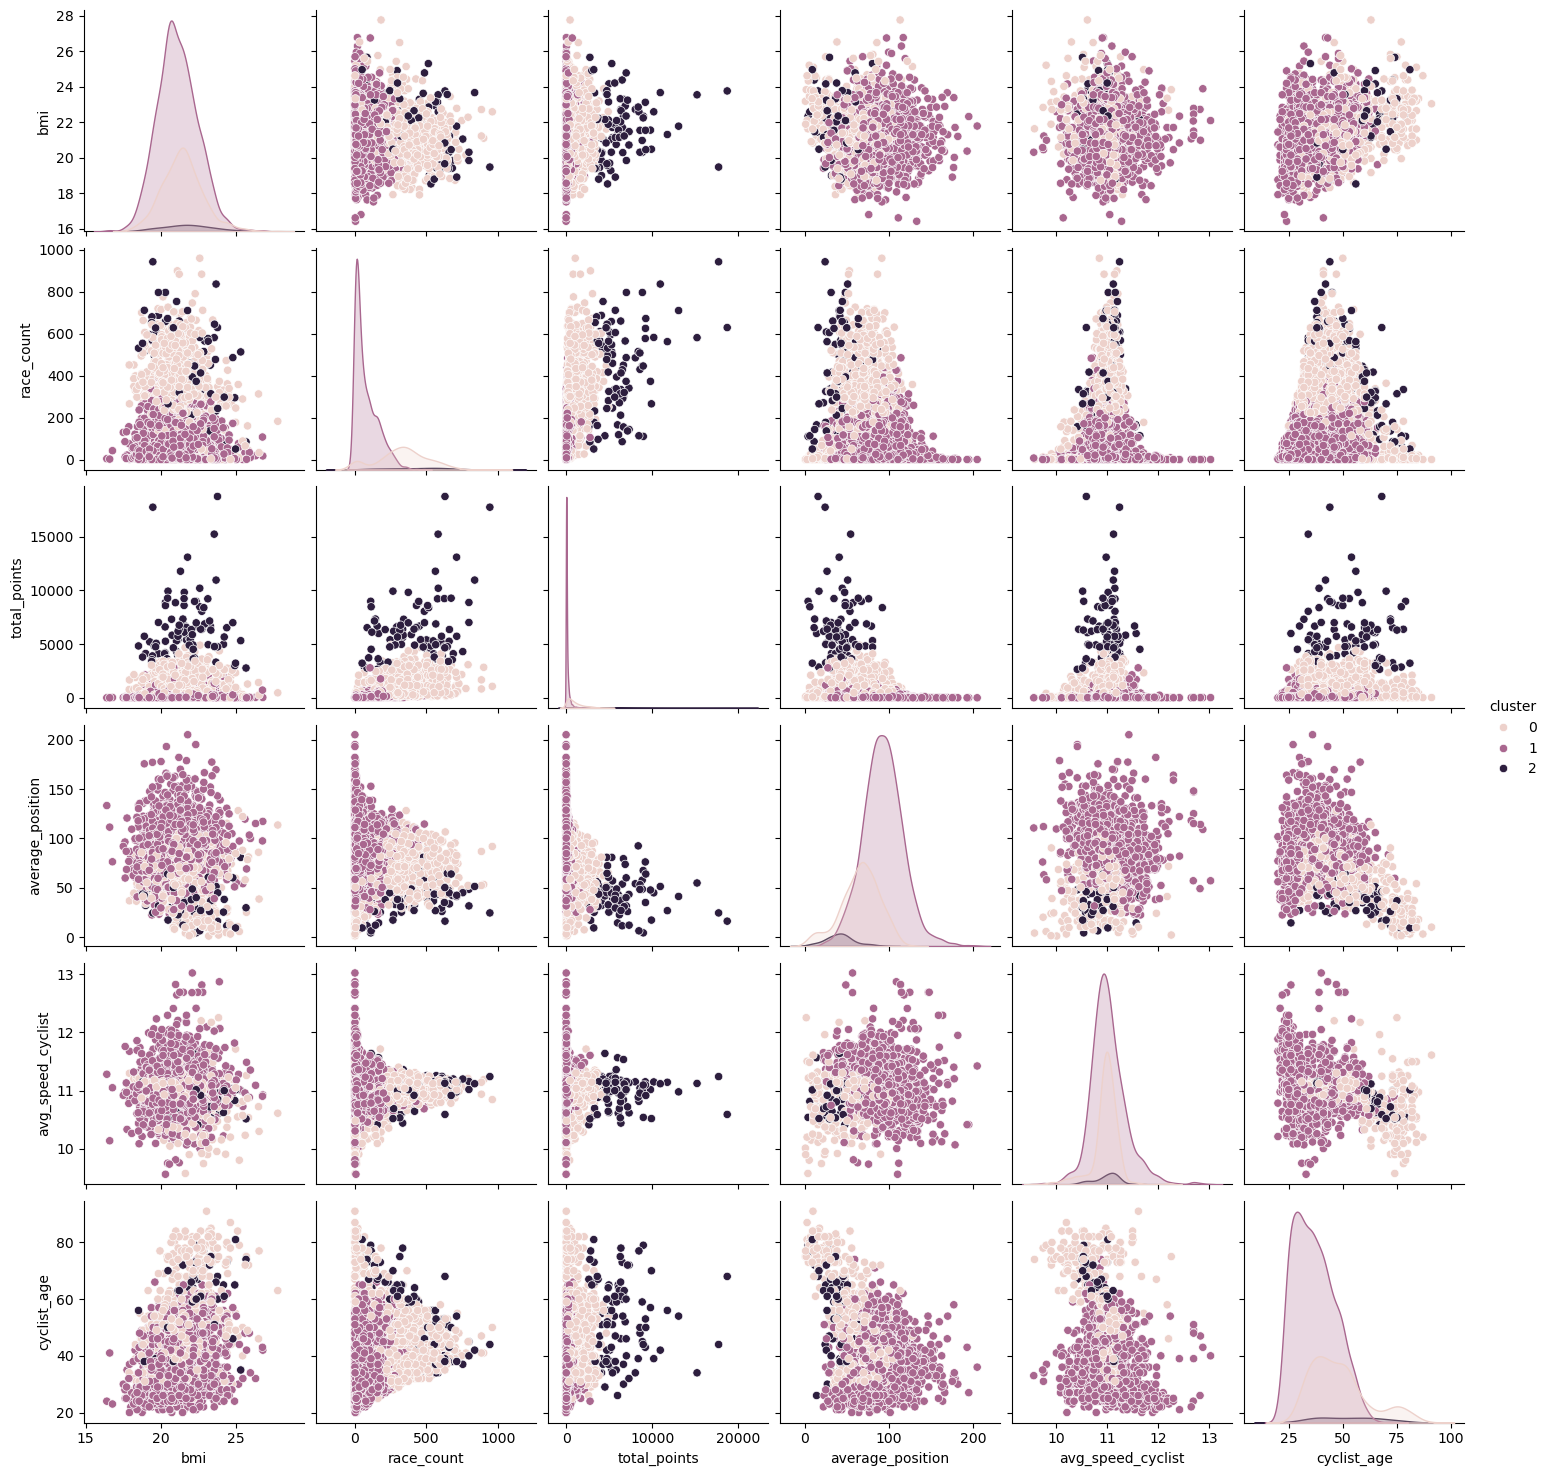

In [31]:
# plot all pairs of values and color by cluster
sns.pairplot(cyclists_df, hue='cluster')
plt.show()

In [32]:
avg_cycl, _ = get_average_per_cluster(labels, cyclists_df)
avg_cycl

bmi  race_count  total_points  average_position  \
cluster                                                          
0        21.438289  331.900613   1019.190184         65.762248   
1        21.100497   78.347584    117.866171         92.790634   
2        21.768423  433.611111   6448.277778         41.779786   

         avg_speed_cyclist  cyclist_age  cluster_size  
cluster                                                
0                10.960977    48.342331           815  
1                11.018607    36.935409          2152  
2                10.992790    52.655556            90

The division here seems to follow the same approach as before, being more lenient towards getting cyclists out of the "mediocre" cluster<br>
The first cluster, that of cyclists that made it out of amateurship, is far bigger than the results of the previous linkages, with an higher number of races, smaller total points and higher average position, indicating that there are people here that run more but win less. We may say that Ward's method considers above amateurs even cyclists that have worse performances, on average, than those who were firstly detected as such by other algorithms. <br>
The second cluster represents those with the worst performances. Considering the fact that the performances of this cluster worsened with respect to race count, total points and average positions, we can say that Ward's method better "isolates" these cases. <br>
The third cluster remains the elite cluster, which now has 90 members instead of 7. Its performances result a bit hindered while its mean age is far reduced. This is probably because among historical ciclists even alive ones made it here.


Let's see how this clustering appears in tridimensional space. We'll use UMAP to reduce its dimensionality.

In [33]:
reducer = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [34]:
reduced_data = reducer.fit_transform(cyc_normalized)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [35]:
# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': ward_linkage.labels_
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df,
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

fig.show()

It's interesting to note the tendril-like nature of the clusters that separated themselves from the "core" represented by the mediocre cyclists. Aside from a few outliers, the clusters seem to have kept some sort of silhoutte.

# Races

Let's scale the data

In [8]:
rac_normalizer , rac_normalized = scale_data(races_df)

Let's check how the silhouette scores for the selected linkage types and maximum clusters compare

In [37]:
if RUN_GRID_SEARCH: 
    search_results = hier_search(hyperparametrs, rac_normalized, samples = 80)
    display(search_results)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning:

The total space of parameters 28 is smaller than n_iter=80. Running 28 iterations. For exhaustive searches, use GridSearchCV.



n_clusters   linkage  random_state  silhouette
14           3   average            42    0.434822
21           3      ward            42    0.432867
15           4   average            42    0.409342
22           4      ward            42    0.349072
16           5   average            42    0.316961
7            3  complete            42    0.290350
26           8      ward            42    0.289420
24           6      ward            42    0.287488
25           7      ward            42    0.285891
17           6   average            42    0.282769
8            4  complete            42    0.279808
23           5      ward            42    0.278490
18           7   average            42    0.275384
9            5  complete            42    0.267947
27           9      ward            42    0.259628
10           6  complete            42    0.255034
11           7  complete            42    0.245558
12           8  complete            42    0.220749
19           8   average            42    0.217736
20           9   average            42    0.216777
13           9  complete            42    0.201359
0            3    single            42    0.182105
1            4    single            42    0.181662
5            8    single            42    0.111680
4            7    single            42    0.110993
3            6    single            42    0.110286
2            5    single            42    0.104667
6            9    single            42    0.037076

Let's see how the first three results fared out

In [9]:
first_linkage_races = AgglomerativeClustering(n_clusters=3, linkage='average')
second_linkage_races = AgglomerativeClustering(n_clusters=3, linkage='ward')
third_linkage_races = AgglomerativeClustering(n_clusters=4, linkage='average')

## First Linkage

In [39]:
labels = first_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

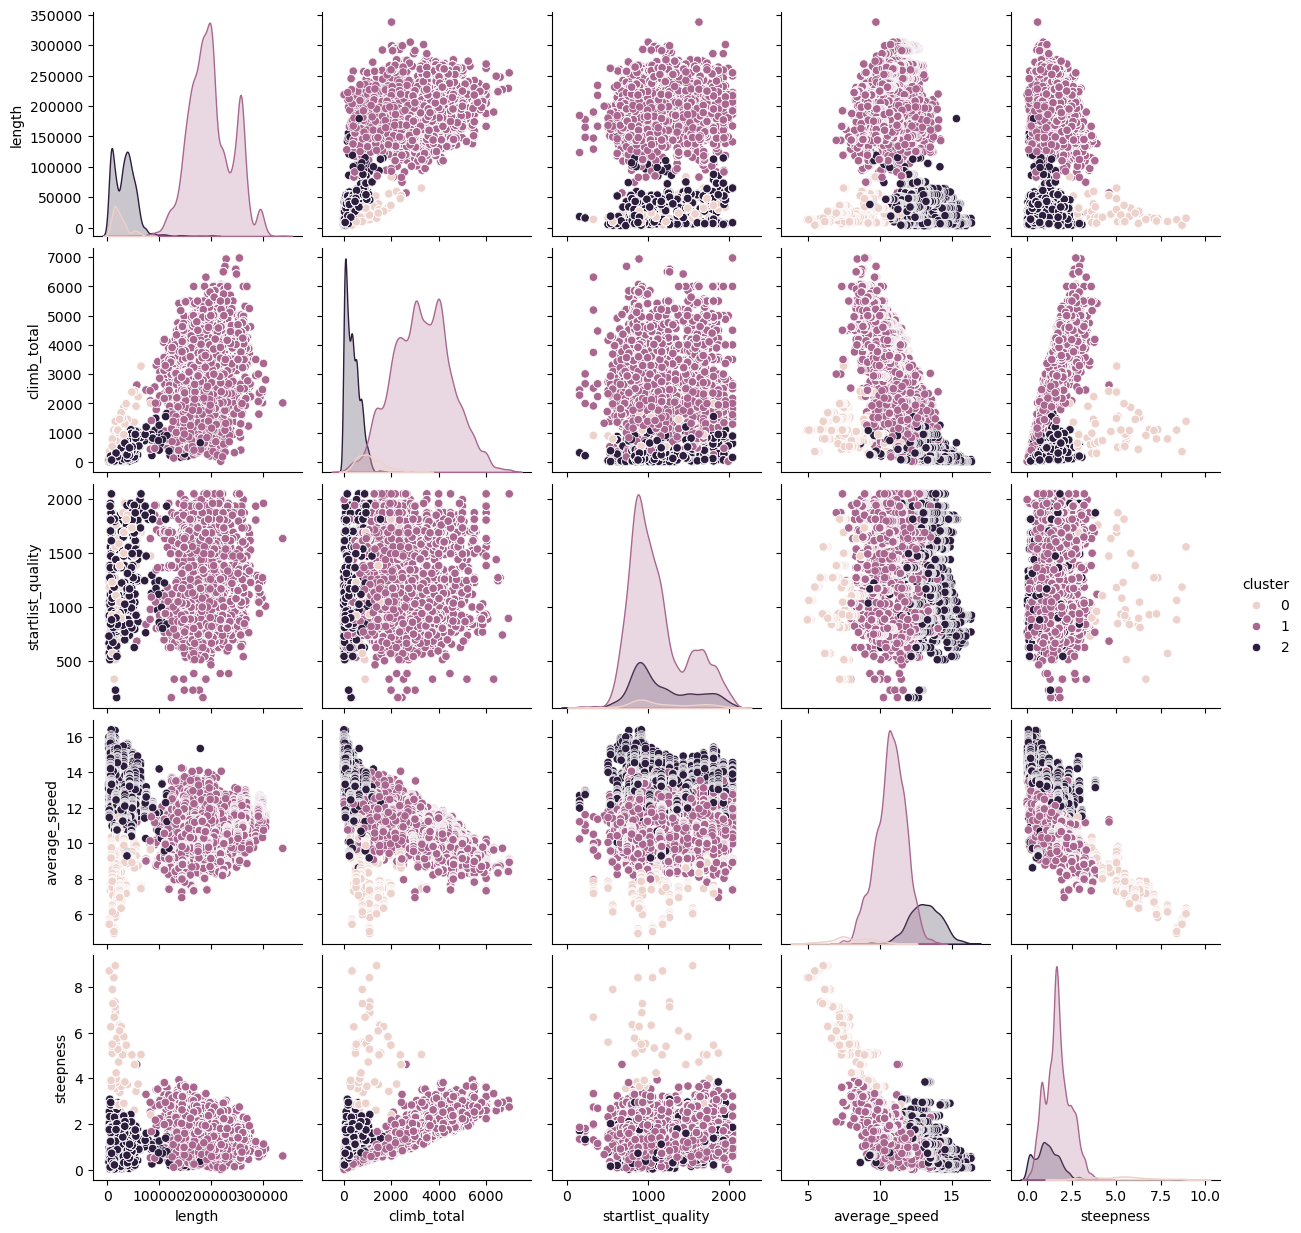

In [40]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [41]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0         24422.442396  1156.024578        1180.084485       8.027780   
1        199452.299637  3293.457395        1114.734515      10.731507   
2         33113.638822   362.760517        1180.462139      13.122269   

         steepness  cluster_size  
cluster                           
0         5.187962           651  
1         1.716081         14611  
2         1.117254          3328

The first cluster denotes shorter, steeper races that proved to be more challenging, considering the very slow speed achieved albeit being the cluster with the highest startlist_quality. The cluster is relatively small, hinting that races that are this difficult only compose a small subset of all the races. <br>
The second cluster, which is the biggest, with an average length of 200km, denotes all the longer races, which are more endurance-focused. An higher average speed wrt to the first cluster is expected because the steepness dramatically falls, indicating less aggressive albeit longer climbs, while it is also expected to be smaller than the next cluster because of its length. Here, the startlist quality is the smallest, indicating with the fact that the cluster size is so high, that races are more common and faced by more people with different skill levels. <br>
The third cluster indicates races that are on almost flat terrain, with the highest average speeds. These sprint-races present a bit of a higher startlist quality that indicates they are dwelled by slightly more professional individuals, instead of being the 3000 participants marathons.

Since it's the best one in terms of silhouette and looks reasonably well divided, let's visualize it with UMAP

In [42]:
reducer_races = umap.UMAP(n_neighbors=15, learning_rate=0.1, n_components=3, random_state=RANDOM_STATE)

In [43]:
reduced_data = reducer_races.fit_transform(rac_normalized)

/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [44]:
# Prepare data for Plotly
df = pd.DataFrame({
    'UMAP 1': reduced_data[:, 0],
    'UMAP 2': reduced_data[:, 1],
    'UMAP 3': reduced_data[:, 2],
    'Cluster': labels
})

# Create interactive 3D scatter plot
fig = px.scatter_3d(
    df.iloc[:5000],
    x='UMAP 1',
    y='UMAP 2',
    z='UMAP 3',
    color='Cluster',
    title='UMAP 3D',
    color_continuous_scale='Viridis'
)

fig.show()

We had to reduce the number of plotted points to keep my laptop from imploding into a singularity. <br>
It looks like there is a central bulk (the long races) from which the first and the second cluster "escape from", like tendrils, to characterize themselves in different ways. Homogeneity looks all but kept, mainly because of the giant differences in size of the clusters and the sample of data to represent.

## Second Linkage

In [11]:
labels = second_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

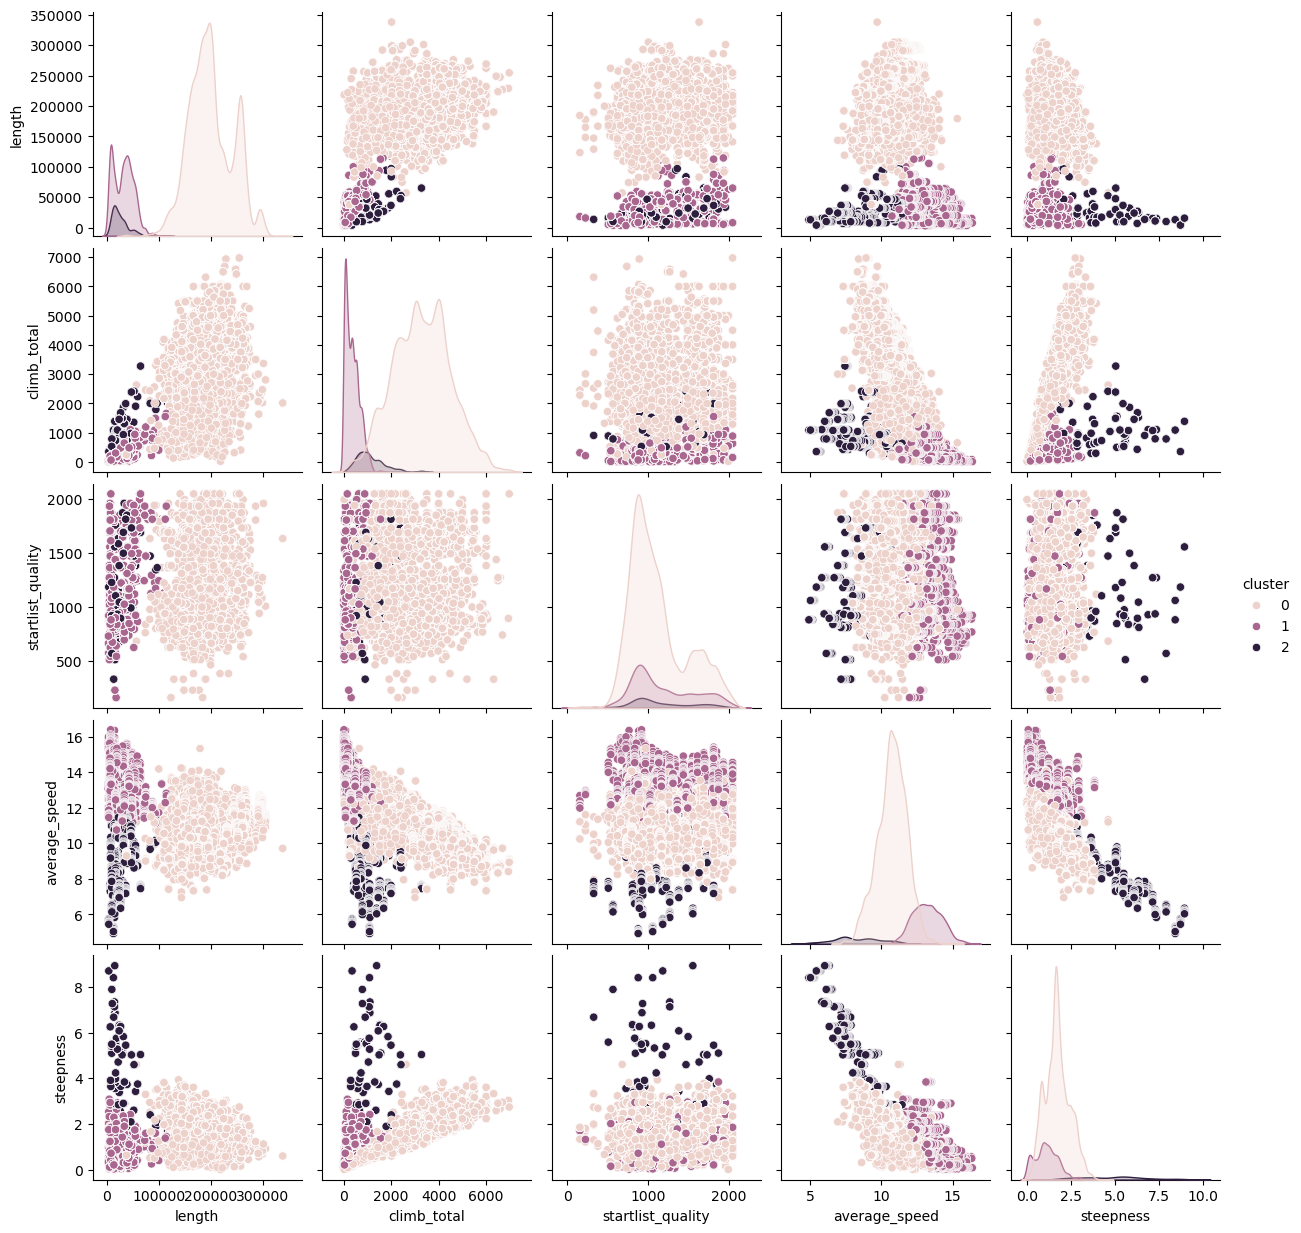

In [12]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [13]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0        199183.254846  3285.174311        1114.251502      10.730076   
1         32129.034161   355.052484        1186.729193      13.205251   
2         25640.961003  1118.247911        1165.623955       8.296739   

         steepness  cluster_size  
cluster                           
0         1.712383         14652  
1         1.106576          3220  
2         4.897248           718

Ward's method looks very similar to average. <br>
Again, the average speed and steepness both from the graphs and from the means seems to have been a determining factor. <br>
The clusters are the same as before, so nothing much can be said. 

## Third Linkage

In [10]:
labels = third_linkage_races.fit_predict(rac_normalized)
races_df['cluster'] = labels

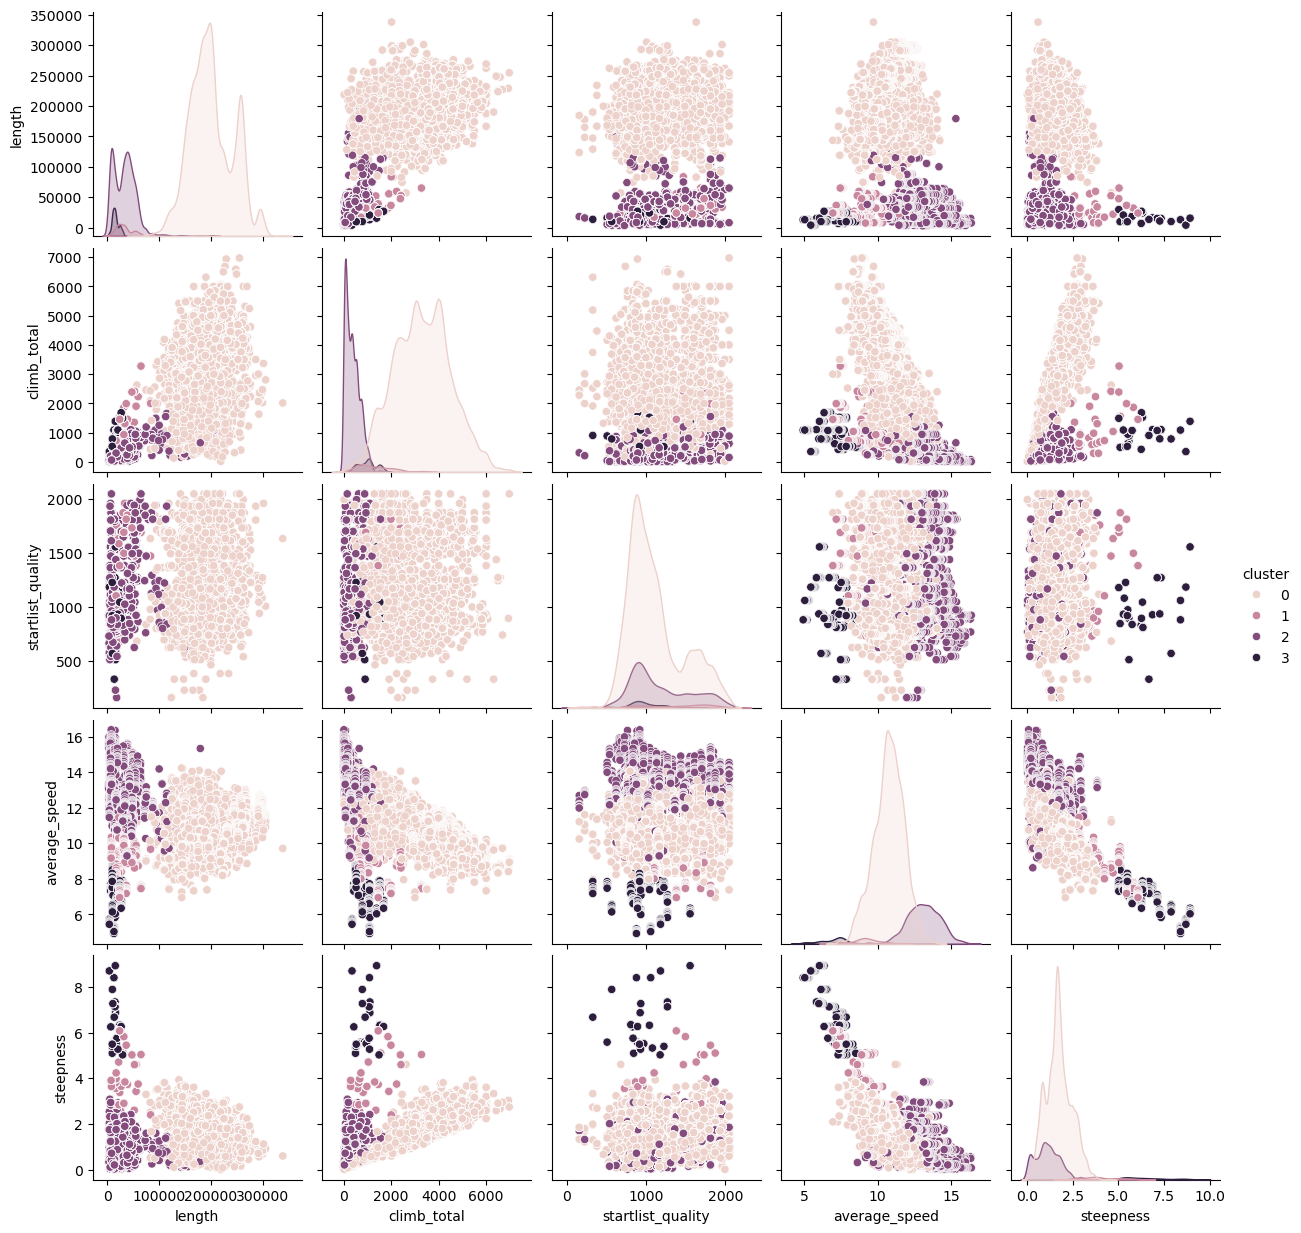

In [11]:
# plot all pairs of values and color by cluster
sns.pairplot(races_df, hue='cluster')
plt.show()

In [12]:
avg_cycl, _ = get_average_per_cluster(labels, races_df)
avg_cycl

length  climb_total  startlist_quality  average_speed  \
cluster                                                                 
0        199452.299637  3293.457395        1114.734515      10.731507   
1         32429.941003  1300.233038        1381.849558       9.037087   
2         33113.638822   362.760517        1180.462139      13.122269   
3         15721.987179   999.336538         960.858974       6.931128   

         steepness  cluster_size  
cluster                           
0         1.716081         14611  
1         3.983054           339  
2         1.117254          3328  
3         6.497140           312

In this clustering, which is the first with one more split, we can see how average decided to aggregate the short and steep clusters.
One is more skewed towards the 33km limit, whie maintaining very high climbing distances, while the other is more skewed towards shortest tracks (15km). An interesting thing is that this division between cluster 1 and 3 breaks the assumption that the climb total decreases monotonically between clusters ordered by length <br> We can see that, as races get longer, the average steepness descends, giving less importance to very difficult climbing sections. 


# Dendograms

Let's check the dendograms produced by the different clustering algorithms

In [13]:
# build the dendogram for single linkage
Z = linkage(cyc_normalized, method='single')
plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.show()

NameError: name 'cyc_normalized' is not defined